In [2]:
import numpy as np
import random
import math
import os
import time
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F


# Basic libs
import numpy as np
import sys

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!unzip "drive/MyDrive/ModelNet40_PLY.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ModelNet40_PLY/monitor/train/monitor_0394.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0395.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0396.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0397.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0398.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0399.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0400.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0401.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0402.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0403.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0404.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0405.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0406.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0407.ply  
  inflating: ModelNet40_PLY/monitor/train/monitor_0408.ply  
  inflating: ModelNet40_PLY/monito

In [5]:
# Define PLY types
ply_dtypes = dict([
    (b'int8', 'i1'),
    (b'char', 'i1'),
    (b'uint8', 'u1'),
    (b'uchar', 'b1'),
    (b'uchar', 'u1'),
    (b'int16', 'i2'),
    (b'short', 'i2'),
    (b'uint16', 'u2'),
    (b'ushort', 'u2'),
    (b'int32', 'i4'),
    (b'int', 'i4'),
    (b'uint32', 'u4'),
    (b'uint', 'u4'),
    (b'float32', 'f4'),
    (b'float', 'f4'),
    (b'float64', 'f8'),
    (b'double', 'f8')
])

# Numpy reader format
valid_formats = {'ascii': '', 'binary_big_endian': '>',
                 'binary_little_endian': '<'}


#------------------------------------------------------------------------------------------
#
#           Functions
#       \***************/
#

def parse_header(plyfile, ext):

    # Variables
    line = []
    properties = []
    num_points = None

    while b'end_header' not in line and line != b'':
        line = plyfile.readline()
    
        if b'element' in line:
            line = line.split()
            num_points = int(line[2])

        elif b'property' in line:
            line = line.split()
            properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))

    return num_points, properties




def read_ply(filename):
    """
    Read ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to read.

    Returns
    -------
    result : array
        data stored in the file

    Examples
    --------
    Store data in file

    >>> points = np.random.rand(5, 3)
    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example.ply', [points, values], ['x', 'y', 'z', 'values'])

    Read the file

    >>> data = read_ply('example.ply')
    >>> values = data['values']
    array([0, 0, 1, 1, 0])
    
    >>> points = np.vstack((data['x'], data['y'], data['z'])).T
    array([[ 0.466  0.595  0.324]
           [ 0.538  0.407  0.654]
           [ 0.850  0.018  0.988]
           [ 0.395  0.394  0.363]
           [ 0.873  0.996  0.092]])

    """

    with open(filename, 'rb') as plyfile:


        # Check if the file start with ply
        if b'ply' not in plyfile.readline():
            raise ValueError('The file does not start whith the word ply')

        # get binary_little/big or ascii
        fmt = plyfile.readline().split()[1].decode()
        if fmt == "ascii":
            raise ValueError('The file is not binary')

        # get extension for building the numpy dtypes
        ext = valid_formats[fmt]

        # Parse header
        num_points, properties = parse_header(plyfile, ext)

        # Get data
        data = np.fromfile(plyfile, dtype=properties, count=num_points)


    return data




def header_properties(field_list, field_names):

    # List of lines to write
    lines = []

    # First line describing element vertex
    lines.append('element vertex %d' % field_list[0].shape[0])

    # Properties lines
    i = 0
    for fields in field_list:
        for field in fields.T:
            lines.append('property %s %s' % (field.dtype.name, field_names[i]))
            i += 1

    return lines


        

def write_ply(filename, field_list, field_names):
    """
    Write ".ply" files

    Parameters
    ----------
    filename : string
        the name of the file to which the data is saved. A '.ply' extension will be appended to the 
        file name if it does no already have one.

    field_list : list, tuple, numpy array
        the fields to be saved in the ply file. Either a numpy array, a list of numpy arrays or a 
        tuple of numpy arrays. Each 1D numpy array and each column of 2D numpy arrays are considered 
        as one field. 

    field_names : list
        the name of each fields as a list of strings. Has to be the same length as the number of 
        fields.

    Examples
    --------
    >>> points = np.random.rand(10, 3)
    >>> write_ply('example1.ply', points, ['x', 'y', 'z'])

    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example2.ply', [points, values], ['x', 'y', 'z', 'values'])

    >>> colors = np.random.randint(255, size=(10,3), dtype=np.uint8)
    >>> field_names = ['x', 'y', 'z', 'red', 'green', 'blue', values']
    >>> write_ply('example3.ply', [points, colors, values], field_names)

    """

    # Format list input to the right form
    field_list = list(field_list) if (type(field_list) == list or type(field_list) == tuple) else list((field_list,))
    for i, field in enumerate(field_list):
        if field is None:
            print('WRITE_PLY ERROR: a field is None')
            return False
        elif field.ndim > 2:
            print('WRITE_PLY ERROR: a field have more than 2 dimensions')
            return False
        elif field.ndim < 2:
            field_list[i] = field.reshape(-1, 1)

    # check all fields have the same number of data
    n_points = [field.shape[0] for field in field_list]
    if not np.all(np.equal(n_points, n_points[0])):
        print('wrong field dimensions')
        return False    

    # Check if field_names and field_list have same nb of column
    n_fields = np.sum([field.shape[1] for field in field_list])
    if (n_fields != len(field_names)):
        print('wrong number of field names')
        return False

    # Add extension if not there
    if not filename.endswith('.ply'):
        filename += '.ply'

    # open in text mode to write the header
    with open(filename, 'w') as plyfile:

        # First magical word
        header = ['ply']

        # Encoding format
        header.append('format binary_' + sys.byteorder + '_endian 1.0')

        # Points properties description
        header.extend(header_properties(field_list, field_names))

        # End of header
        header.append('end_header')

        # Write all lines
        for line in header:
            plyfile.write("%s\n" % line)


    # open in binary/append to use tofile
    with open(filename, 'ab') as plyfile:

        # Create a structured array
        i = 0
        type_list = []
        for fields in field_list:
            for field in fields.T:
                type_list += [(field_names[i], field.dtype.str)]
                i += 1
        data = np.empty(field_list[0].shape[0], dtype=type_list)
        i = 0
        for fields in field_list:
            for field in fields.T:
                data[field_names[i]] = field
                i += 1

        data.tofile(plyfile)

    return True


def describe_element(name, df):
    """ Takes the columns of the dataframe and builds a ply-like description

    Parameters
    ----------
    name: str
    df: pandas DataFrame

    Returns
    -------
    element: list[str]
    """
    property_formats = {'f': 'float', 'u': 'uchar', 'i': 'int'}
    element = ['element ' + name + ' ' + str(len(df))]

    if name == 'face':
        element.append("property list uchar int points_indices")

    else:
        for i in range(len(df.columns)):
            # get first letter of dtype to infer format
            f = property_formats[str(df.dtypes[i])[0]]
            element.append('property ' + f + ' ' + df.columns.values[i])

    return element

In [84]:
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),      0],
                               [ math.sin(theta),  math.cos(theta),      0],
                               [0,                               0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud


class RandomNoise(object):
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud


class ShufflePoints(object):
    def __call__(self, pointcloud):
        np.random.shuffle(pointcloud)
        return pointcloud


class Translate(object):
    def __init__(self, range=0.001):
        self.translate_range = range

    def __call__(self, pointcloud):
        translation = np.random.uniform(-self.translate_range, self.translate_range)
        pointcloud += translation
        return pointcloud

class Scale(object):
    def __init__(self, lower_thresh=0.9, higher_thresh=1.1):
        self.low, self.high = lower_thresh, higher_thresh

    def __call__(self, pointcloud):
        scale = np.random.uniform(self.low, self.high)
        pointcloud *= scale
        return pointcloud


class ToTensor(object):
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)


def default_transforms():
    return transforms.Compose([RandomRotation_z(), RandomNoise(), ShufflePoints(), ToTensor()])

def custom_transforms():
    return transforms.Compose([RandomRotation_z(), RandomNoise(), ShufflePoints(), Translate(), Scale(), ToTensor()])



class PointCloudData(Dataset):
    def __init__(self, root_dir, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir+"/"+dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {}
                    sample['ply_path'] = new_dir+"/"+file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'], data['y'], data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}


class PointNetBasic(nn.Module):
    def __init__(self, classes = 40, dropout=0.3,sym ='maxpool'):
        super().__init__()
        
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bnconv1 = nn.BatchNorm1d(num_features=64)
        self.conv2 = nn.Conv1d(64, 64, 1)
        self.bnconv2 = nn.BatchNorm1d(num_features=64)


        self.conv3 = nn.Conv1d(64, 64, 1)
        self.bnconv3 = nn.BatchNorm1d(num_features=64)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.bnconv4 = nn.BatchNorm1d(num_features=128)
        self.conv5 = nn.Conv1d(128, 1024, 1)
        self.bnconv5 = nn.BatchNorm1d(num_features=1024)

        if(sym=='maxpool'):
          self.pool = nn.MaxPool1d(1024)
        if(sym=='avgpool'):
          self.pool = nn.AvgPool1d(1024)
        self.linear1 = nn.Linear(1024, 512)
        self.bnlin1 = nn.BatchNorm1d(num_features=512)
        self.linear2 = nn.Linear(512, 256)
        self.bnlin2 = nn.BatchNorm1d(num_features=256)
        self.linear3 = nn.Linear(256, classes)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)



    def forward(self, input):
        

        x = self.relu(self.bnconv1(self.conv1(input)))
        x = self.relu(self.bnconv2(self.conv2(x)))

        x = self.relu(self.bnconv3(self.conv3(x)))
        x = self.relu(self.bnconv4(self.conv4(x)))
        x = self.relu(self.bnconv5(self.conv5(x)))

        x = self.pool(x)

        flatten = nn.Flatten()
        x = flatten(x)

        x = self.relu(self.bnlin1(self.linear1(x)))
       
        x = self.relu(self.bnlin2(self.linear2(x)))

        x = self.dropout(x)

        x = self.softmax(self.linear3(x))

        return x


class Tnet(nn.Module):
   def __init__(self, k=3,K=1024):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,K,1)
      self.fc1 = nn.Linear(K,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(K)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self,K=1024):
        super().__init__()
        self.input_transform = Tnet(k=3,K=1024)
        self.feature_transform = Tnet(k=64,K=1024)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,K,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(K)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40, K=1024):
        super().__init__()
        self.transform = Transform(K)
        self.fc1 = nn.Linear(K, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [19]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    #if outputs.is_cuda:
    id3x3=id3x3.cuda()
    id64x64=id64x64.cuda()

    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))

    return criterion(outputs, labels) + alpha * (torch.sqrt(torch.sum(torch.mul(diff3x3,diff3x3)))+torch.sqrt(torch.sum(torch.mul(diff64x64,diff64x64)))) / float(bs)

In [20]:
def train(model, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    loss=0
    train_loss = []
    accuracy_list = []
    for epoch in range(epochs): 
        model.train()
        train_loss_t=0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].cuda().float(), data['category'].cuda()
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            train_loss_t += loss.item()
        train_loss.append(train_loss_t/len(train_loader))

        #print('[Epoch: %d / %4d], loss: %.3f' %  (epoch + 1, len(train_loader), loss.item()))

        model.eval()
        correct = total = 0

        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].cuda().float(), data['category'].cuda()
                    outputs,__,__ = model(inputs.transpose(1,2))
                    #outputs, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100. * correct / total
            accuracy_list.append(val_acc)
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' %(epoch+1, loss, val_acc))

        scheduler.step()
    return accuracy_list, train_loss

In [21]:
best= []
idx = []

In [45]:
t0 = time.time()

train_ds = PointCloudData("ModelNet40_PLY")
test_ds = PointCloudData("ModelNet40_PLY", folder='test')

inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)
K=2048
model = PointNet(classes = 40, K=2048)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

model.cuda()

accuracy_list, train_loss = train(model, train_loader, test_loader, epochs = 25)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  4129905
Epoch: 1, Loss: 1.948, Test accuracy: 32.5 %
Epoch: 2, Loss: 1.739, Test accuracy: 52.5 %
Epoch: 3, Loss: 1.311, Test accuracy: 54.3 %
Epoch: 4, Loss: 1.357, Test accuracy: 59.4 %
Epoch: 5, Loss: 0.883, Test accuracy: 66.8 %
Epoch: 6, Loss: 0.994, Test accuracy: 55.4 

In [46]:
idx.append(K)
best.append(max(accuracy_list))

In [54]:
idx

[64, 128, 256, 512, 1024, 2048]

In [67]:
best

[81.9286871961102,
 82.0097244732577,
 82.05024311183145,
 82.17179902755268,
 82.17179902755267,
 82.21231766612642]

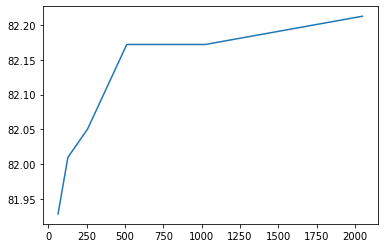

In [68]:
import matplotlib.pyplot as plt
plt.plot(idx,best)
plt.savefig('influenceofK')

In [72]:
def basic_loss(outputs, labels):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    return criterion(outputs, labels)

    
def train(model, train_loader, test_loader=None, epochs=250):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    loss=0
    train_loss = []
    accuracy_list = []
    for epoch in range(epochs): 
        model.train()
        train_loss_t=0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].cuda().float(), data['category'].cuda()
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1,2))

            loss = basic_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_t += loss.item()
        train_loss.append(train_loss_t/len(train_loader))

        #print('[Epoch: %d / %4d], loss: %.3f' %  (epoch + 1, len(train_loader), loss.item()))

        model.eval()
        correct = total = 0

        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].cuda().float(), data['category'].cuda()
                    #outputs,__,__ = model(inputs.transpose(1,2))
                    outputs = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_acc = 100. * correct / total
            accuracy_list.append(val_acc)
            print('Epoch: %d, Loss: %.3f, Test accuracy: %.1f %%' %(epoch+1, loss, val_acc))

        scheduler.step()
    return accuracy_list, train_loss

In [76]:
ind= []
highest = []

In [87]:
t0 = time.time()

train_ds = PointCloudData("ModelNet40_PLY")
test_ds = PointCloudData("ModelNet40_PLY", folder='test')

inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

sym = 'avgpool'
model = PointNetBasic(sym ='avgpool')

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

model.cuda()

accuracy_list, train_loss = train(model, train_loader, test_loader, epochs = 25)

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  819624
Epoch: 1, Loss: 1.111, Test accuracy: 49.8 %
Epoch: 2, Loss: 1.172, Test accuracy: 60.0 %
Epoch: 3, Loss: 0.766, Test accuracy: 64.1 %
Epoch: 4, Loss: 0.896, Test accuracy: 65.5 %
Epoch: 5, Loss: 1.509, Test accuracy: 67.9 %
Epoch: 6, Loss: 0.858, Test accuracy: 68.5 %

In [91]:
accuracy_list

[49.75688816855754,
 60.04862236628849,
 64.10048622366288,
 65.51863857374393,
 67.94975688816855,
 68.47649918962723,
 69.73257698541329,
 73.01458670988654,
 71.51539708265803,
 71.43435980551054,
 73.13614262560777,
 74.7163695299838,
 72.00162074554295,
 75.48622366288492,
 75.89141004862236,
 74.7163695299838,
 77.71474878444084,
 70.09724473257698,
 76.17504051863857,
 76.01296596434359,
 78.68719611021069,
 77.99837925445705,
 79.3354943273906,
 79.25445705024312,
 80.42949756888169]

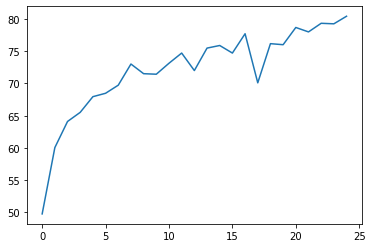

In [93]:
plt.plot(accuracy_list)
plt.savefig('acc')

In [88]:
ind.append(sym)
highest.append(max(accuracy_list))

In [89]:
highest

[84.44084278768233, 80.42949756888169]

In [90]:
ind

['maxpool', 'avgpool']